# Getting Started: RAM Report Data

In the process of generating reports for both record-only and stimulation sessions, the RAM reporting pipeline produces a number of summary data files. These files contain all of the information requried to reproduce the plots, summary statistics, and any analyses contained in the reports. However, another use for these summary files is for conducting alternative post-hoc analyses using the RAM data. In particular, some common use cases for this data are:

1. Post-hoc assessment of classifier performance and/or re-assessment using a different classifier
2. Behavioral analyses comparing cohorts of subjects or comparing stim/no-stim experimental conditions
3. High-level summary information (either behavioral or electrophysiological) across a broad group of subjects

**Data Types**

Each of the summary files saved as part of generating a report has a corresponding python class with various properties and helper methods defined. These classes are documented in the [Seraializeable Data Structures](https://pennmem.github.io/ram_utils/html/data.html) section of the ramutils documentation.

1. Session Summary
2. Math Summary
3. Classifier Summary
4. Target Selection Table 
5. Retrained Classifier


**Common Patterns**

The remainder of this guide will go through some common usage patterns for interacting with the saved data including:

1. Finding data
2. Loading multiple files of a single type
3. Extracting metadata from a file path
4. Building an item-level dataset
5. Reloading a trained classifier
6. Pandas magic
7. Combining across summary file types

## Finding Data

In [1]:
from ramutils.tasks.misc import load_existing_results

Could not import MorletWaveletFilterCppLegacy (single-core C++ version of MorletWaveletFilter): cannot import name 'MorletWaveletTransform'
You can still use MorletWaveletFilter


In [2]:
rhino_root = '/Volumes/RHINO/'
report_db_location = "/Volumes/RHINO/data10/RAM/report_database/"

For loading all saved data associated with a single subject/experiment combination (either a single session or multiple sessions), you can use the load_existing_results helper function. Internally, this function is used to load data for producing aggregate reports. A dictionary is returned whose keys indicate the type of underlying data. The values are a list of the summary objects, one per session. For this example, we are loading a single session.

In [3]:
# .compute() is required because load_existing_results is actual a task, which
# is lazily evaluated by default
results_dict = load_existing_results(subject='R1389J', experiment='catFR5', 
                                     sessions=[1], stim_report=True, 
                                     db_loc=report_db_location, rootdir=rhino_root).compute()
list(results_dict.keys())

[I 2018-05-16 15:11:47,221 _wrapper.py:21] calling load_existing_results


['target_selection_table',
 'classifier_evaluation_results',
 'session_summaries',
 'math_summaries',
 'hmm_results']

In [4]:
classifier_data = results_dict['classifier_evaluation_results'][0]
print("Data is saved as a {} object.\nAUC for this session: {}".format(type(classifier_data), classifier_data.auc))

Data is saved as a <class 'ramutils.reports.summary.ClassifierSummary'> object.
AUC for this session: 0.6512345679012346


In [5]:
session_data = results_dict['session_summaries'][0]
print("Data is saved as a {} object.\nSession Completed On: {}".format(type(session_data), 
                                                                       session_data.session_datetime))

Data is saved as a <class 'ramutils.reports.summary.FRStimSessionSummary'> object.
Session Completed On: 2018-02-28 16:47:02.190000+00:00


In [6]:
math_data = results_dict['math_summaries'][0]
print("Data is saved as a {} object.\nSubject answer {}% math problems correctly".format(type(math_data),
                                                                                          math_data.percent_correct))

Data is saved as a <class 'ramutils.reports.summary.MathSummary'> object.
Subject answer 79.76190476190476% math problems correctly


## Loading Multiple Files of a Single Type

In [7]:
import os
import glob

from ramutils.reports.summary import FRStimSessionSummary

fr5_session_summary_locations = glob.glob(os.path.join(report_db_location, '*FR5*session_summary*'))
print("Found {} FR5 or catFR5 session summaries".format(len(fr5_session_summary_locations)))

Found 58 FR5 or catFR5 session summaries


In [8]:
session_summaries = []
for summary_loc in fr5_session_summary_locations:
    summary = FRStimSessionSummary.from_hdf(summary_loc)
    session_summaries.append(summary)

## Extracting Metadata from the File Path

As noted in the documentation, underlying files are stored with a specific naming convention so that they can be easily differentiated despite residing in the same directory. ramutils has a utility function for extracting this metadata from the file path, which can be handy when combining multiple files of a single type or across types

In [9]:
from ramutils.utils import extract_report_info_from_path

metadata = extract_report_info_from_path(fr5_session_summary_locations[0])
metadata

{'subject': 'R1275D',
 'experiment': 'FR5',
 'montage': 0,
 'sessions': [1],
 'file_name': 'session_summary',
 'file_type': 'h5'}

## Building an Item-Level Dataset
One of the properties of the session summary objects is a dataframe containing all of the encoding events from the session that has been enriched with stimulation parameter information and other metadata in the case of a stimulation session. One common use case is to perform some sort of behavioral analysis that requires item-level information. Oftentimes, this analysis is done across subjects and experiments. Luckily, there is a helper method to make it rather trivial to combine this item-level information and return a Pandas Dataframe

In [10]:
combined_item_df = FRStimSessionSummary.combine_sessions(session_summaries)
combined_item_df.head()

,serialpos,session,subject,experiment,mstime,type,recalled,list,is_stim_list,phase,...,is_stim_item,is_post_stim_item,thresh,classifier_output,location,amplitude,pulse_freq,stim_duration,stimAnodeTag,stimCathodeTag
0,1,1,R1275D,FR5,1497112517408,WORD,0,1,0,BASELINE,...,0,0,0.5,0.565596,nan,nan,nan,nan,nan,nan
1,2,1,R1275D,FR5,1497112520131,WORD,0,1,0,BASELINE,...,0,0,0.5,0.647678,nan,nan,nan,nan,nan,nan
2,3,1,R1275D,FR5,1497112522816,WORD,0,1,0,BASELINE,...,0,0,0.5,0.358846,nan,nan,nan,nan,nan,nan
3,4,1,R1275D,FR5,1497112525335,WORD,0,1,0,BASELINE,...,0,0,0.5,0.459033,nan,nan,nan,nan,nan,nan
4,5,1,R1275D,FR5,1497112527751,WORD,0,1,0,BASELINE,...,0,0,0.5,0.446794,nan,nan,nan,nan,nan,nan


We previously found 58 sessions worth of data. At 300 encoding events per session, we should have around 17,400 rows in our dataset, unless some sessions were incomplete

In [11]:
len(combined_item_df)

16548

## Reloading a Trained Classifier

Another useful set of information is the classifier itself, rather than just the classifier evaluation results. There are two ways to get this data. The best way is to load the classifier that was actually used during the session. Ramutils has a helpfer function to do this loading for you. The benefit of using this classifier is that it should allow you to exactly match what occured during the session, since this is the classifier that Ramulator was using. If channels were excluded because of some artifact detection routine(s), there will be no need to deal with this post-hoc. Unfortunately, having a consistent storage format is a relatively recent development, so for older subjects it will not be possible to load the actual classifier used. Instead, you can use the classifier trained with the default parameters (frequencies, timings, etc.) that is saved to the report database directory. 

You can find more information about the storage format of the classifier by looking at the [documentation](https://pennmem.github.io/classiflib/html/index.html)

In [12]:
# Reloading the used classifier
from ramutils.classifier.utils import reload_classifier

classifier_container = reload_classifier('R1387E', 'catFR5', 1, mount_point='/Volumes/RHINO/')
classifier_container.features.shape # n_events x n_features power matrix

(997, 872)

In [13]:
# Loading the classifier from the reports database
from classiflib.container import ClassifierContainer

retrained_classifier_loc = glob.glob(os.path.join(report_db_location, 'R1387E_catFR5_all_retrained_classifier*'))[0]
classifier_container = ClassifierContainer.load(retrained_classifier_loc)
classifier_container.features.shape

(997, 968)

In this case, we can see that the classifier used during the session differs from the one that does not take into account artifactual channels. In fact, we can deduce that 12 channels were exclude due to artifact detection (12 * 8 = 968 - 972). 

Once a classifier has been loaded, the main use cases are to make out of sample predictions and check on the AUC from the training session.

Training AUC: 0.61


/Users/zduey/miniconda3/envs/ramutils_dev/envs/ramutils_test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


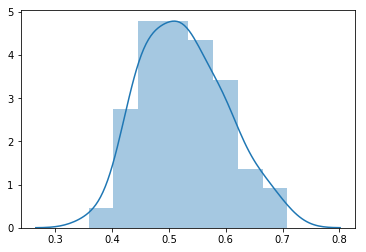

In [14]:
import numpy as np
import seaborn as sns

%matplotlib inline

classifier = classifier_container.classifier

print("Training AUC: {:.2f}".format(classifier_container.classifier_info['auc']))

# Create 100 random new events and calculated predicted probabilities
out_of_sample_powers = np.random.normal(size=(100, classifier_container.features.shape[1]))
predicted_probs = classifier.predict_proba(out_of_sample_powers)[:, 1]
sns.distplot(predicted_probs)

## Pandas Magic

One pattern that has come in handy for almost every cross-subject analysis, is the ability to embed these summary objects in a pandas dataframe. Bear with me as this sounds strange, but what it allows you to do is to write your own functions that operate on a summary object and return some information. These functions can then make use of the pandas API to quickly apply the transformation to all session summaries in a series. In this way, you can easily extend the built-in set of methods that operate on these summary objects. Let's go through a quick example.

First, we will define some custom function that takes a summary object as its input. In this case, we have some behavioral measure of recall performance that we want to calculate that is not part of the standard set of methods.

In [15]:
def normalized_item_delta_recall(summary):
    """ Calculate normalized delta recall at the item level 
    
    Parameters
    ----------
    summary: ramutils.reports.summary.FRStimSessionSummary
        Helper class containing events, powers, montage, and other information needed to analyze a single
        stimulation session
    
    Returns
    -------
    normalized_delta_recall: float
        Item-level measure of the change in recall performance due to stimulation. Calculated by
        comparing the recall rates for stimulated items with items for non-stim lists that would
        have been stimulated
    
    """
    if type(summary) != list:
        summary = [summary]
    df = FRStimSessionSummary.combine_sessions(summary)
    nonstim_low_bio_recall = df[(df.classifier_output < df.thresh) &
                                (df.is_stim_list == False)].recalled.mean()
    stim_recall = df[df.is_stim_item == True].recalled.mean()
    overall_recall = df.recalled.mean()
    normalized_delta_recall = 100 * ((stim_recall - nonstim_low_bio_recall) / overall_recall)
    return normalized_delta_recall

Next, we will calculate normalized item-level delta recall using two different methods. This first method uses list comprehension, and the second uses the session summary objects embedded in a pandas dataframe.

In [16]:
normalized_delta_recall = [normalized_item_delta_recall(summary) for summary in session_summaries]

Ok, so great. Now we have this list of values that we wanted to extract. We can do some simple things with it:

In [17]:
print("Average item-level delta recall: {:.2f}%".format(np.nanmean(np.array(normalized_delta_recall))))
print("Biggest item-level delta recall: {:.2f}%".format(max(normalized_delta_recall)))
print("Biggest adverse item-level delta recall: {:.2f}%".format(min(normalized_delta_recall)))

Average item-level delta recall: 4.24%
Biggest item-level delta recall: 87.69%
Biggest adverse item-level delta recall: -60.29%


This works pretty well for doing some basic manipulations and even plotting, but what if we want to ask some slightly less trivial questions? For example, what is the mean, min, max delta recall split by FR5/catFR5? What if we want to split based on stimulation region or some other value? This is no longer straightforward to do with the list-based method. Instead, let's get these summary objects into a pandas dataframe and really let the analyses run wild.

In [18]:
import pandas as pd

session_data = {
    'subject': [],
    'experiment': [],
    'session': [],
    'session_summary': [],
    'montage': [],
    'anode': [],
    'cathode': [],
    'electrode_type': [],
    'location': [],
    'amplitude': [],
    'pulse_freq': [],
    'stim_duration': [],
    'date': []
}

for session_summary_loc in fr5_session_summary_locations:
    metadata = extract_report_info_from_path(session_summary_loc)
    session_summary = FRStimSessionSummary.from_hdf(session_summary_loc)
    session_df = pd.DataFrame.from_records(session_summary._events)
    stim_params = FRStimSessionSummary.stim_parameters([session_summary])[0]
    
    session_data['subject'].append(metadata['subject'])
    session_data['experiment'].append(metadata['experiment'])
    session_data['session'].append(metadata['sessions'][0])
    session_data['session_summary'].append(session_summary)
    session_data['montage'].append(metadata['montage'])
    session_data['anode'].append(stim_params['stimAnodeTag'])
    session_data['cathode'].append(stim_params['stimCathodeTag'])
    session_data['electrode_type'].append('')
    session_data['location'].append(stim_params['location'])
    session_data['amplitude'].append(float(stim_params['amplitude']))
    session_data['pulse_freq'].append(float(stim_params['pulse_freq']))
    session_data['stim_duration'].append(float(stim_params['stim_duration']))
    session_data['date'].append(session_summary.session_datetime)

In [19]:
session_df = pd.DataFrame.from_dict(session_data)
session_df = session_df[['subject', 'experiment', 'montage', 'session', 
                         'date', 'session_summary', 'electrode_type', 'location',
                         'pulse_freq', 'stim_duration']]
session_df.head()

,subject,experiment,montage,session,date,session_summary,electrode_type,location,pulse_freq,stim_duration
0,R1275D,FR5,0,1,2017-06-10 17:15:09.603000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 1, 'R1275...",,Right Cerebral White Matter,200.0,500.0
1,R1275D,FR5,0,2,2017-06-11 17:29:07.115000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 2, 'R1275...",,Right Cerebral White Matter,200.0,500.0
2,R1292E,FR5,0,0,2017-07-03 16:12:42.221000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 0, 'R1292...",,Left Middle Temporal Gyrus,100.0,500.0
3,R1304N,FR5,0,0,2017-05-29 15:35:00.879000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 0, 'R1304...",,Right Cerebral White Matter,200.0,500.0
4,R1308T,FR5,0,0,2017-06-19 20:33:04.856000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 0, 'R1308...",,Left Middle Temporal Gyrus,200.0,500.0


So it was not as easy to generate as the list, but we ended with a nice user-friend data structure that is going to open up a lot of doors for doing our analyses that were previously much more complicated. Let's start by creating a new variable in the dataset to represent the normalized item-level delta recall metric that we calculated before.

In [20]:
session_df['delta_recall'] = session_df['session_summary'].apply(normalized_item_delta_recall)
session_df.head()

,subject,experiment,montage,session,date,session_summary,electrode_type,location,pulse_freq,stim_duration,delta_recall
0,R1275D,FR5,0,1,2017-06-10 17:15:09.603000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 1, 'R1275...",,Right Cerebral White Matter,200.0,500.0,35.411540
1,R1275D,FR5,0,2,2017-06-11 17:29:07.115000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 2, 'R1275...",,Right Cerebral White Matter,200.0,500.0,-7.532247
2,R1292E,FR5,0,0,2017-07-03 16:12:42.221000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 0, 'R1292...",,Left Middle Temporal Gyrus,100.0,500.0,5.376644
3,R1304N,FR5,0,0,2017-05-29 15:35:00.879000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 0, 'R1304...",,Right Cerebral White Matter,200.0,500.0,55.067482
4,R1308T,FR5,0,0,2017-06-19 20:33:04.856000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 0, 'R1308...",,Left Middle Temporal Gyrus,200.0,500.0,NaN


If that doesn't get you excited, then I don't know what will and you may as well stop reading this tutorial. For the sake of completeness, let's replicate what we did before... and more...

In [21]:
print("Average item-level delta recall: {:.2f}%".format(session_df['delta_recall'].mean()))
print("Biggest item-level delta recall: {:.2f}%".format(session_df['delta_recall'].max()))
print("Biggest adverse item-level delta recall: {:.2f}%".format(session_df['delta_recall'].min()))

Average item-level delta recall: 4.24%
Biggest item-level delta recall: 87.69%
Biggest adverse item-level delta recall: -60.29%


In [22]:
session_df.groupby(by='experiment').agg({'delta_recall': ['mean', 'min', 'max']})

delta_recall                      
                   mean        min        max
experiment                                   
FR5            3.739698 -60.293627  87.689632
catFR5         4.622367 -39.462656  61.873683

In [23]:
session_df.groupby(by='location').agg({'delta_recall': ['mean', 'min', 'max']})

delta_recall                      
                                    mean        min        max
location                                                      
--                            -12.920880 -23.027612  -0.691512
Left Cerebral White Matter    -28.169914 -28.169914 -28.169914
Left Middle Temporal Gyrus     10.327724 -36.400404  87.689632
Left caudalmiddlefrontal      -26.389477 -35.246487 -17.532468
Left inferiortemporal          29.324192  29.324192  29.324192
Left middletemporal             6.031860 -39.462656  61.873683
Left precentral                 6.639869   6.639869   6.639869
Left rostralmiddlefrontal       1.668592   1.668592   1.668592
Right Cerebral White Matter     5.663287 -60.293627  55.067482
Right MCg                       2.332751  -4.132304   8.797806
Right Middle Temporal Gyrus    16.338604 -45.993947  78.671155
Right caudalmiddlefrontal      11.732229  11.732229  11.732229
Right middletemporal           -3.304355 -28.242959  21.634249
Right parstriangularis         12.677112  -3.591954  28.946178
Right rostralmiddlefrontal     13.461996   5.021732  22.924525
Right superiorfrontal          -4.072398  -4.072398  -4.072398
Right superiortemporal         -8.582085 -12.624835  -1.666667

We just answered the two questions we posed previously in one line of code of each. Try doing that with a recarray all you doubters out there.

## Combining Across Summary File Types

So far, we have been taking a look at the data contained in each of these summary objects in isolation. However, for many analyses, you may want to combine the information contained in each. For example, the most commone usage pattern is to combine information about the trained classifier, the classifier results from the session, and the session summary data. The three of those together open up a world of possibilities for your analyses. To do this, we are going to generalize the "Pandas magic" approach by creating a dataframe containing the summary object of interest and then rely on the merging mechanics available through pandas to get all of this data into a single data structure.

In [24]:
from ramutils.reports.summary import ClassifierSummary

# Repeat the process for getting summary objects into a dataframe that we used for the session summaries
classifier_summaries = glob.glob(os.path.join(report_db_location, '*FR5*classifier_session*'))

classifier_summary_data = {
    'subject': [],
    'experiment': [],
    'session': [],
    'classifier_summary': [],
    'montage': [],
    'auc': [],
    'pvalue': []
}

for summary_dir in classifier_summaries:
    summary = ClassifierSummary.from_hdf(summary_dir)
    metadata = extract_report_info_from_path(summary_dir)
    classifier_summary_data['subject'].append(metadata['subject'])
    classifier_summary_data['experiment'].append(metadata['experiment'])
    classifier_summary_data['session'].append(metadata['sessions'][0])
    classifier_summary_data['classifier_summary'].append(summary)
    classifier_summary_data['montage'].append(metadata['montage'])
    classifier_summary_data['auc'].append(summary.auc)
    classifier_summary_data['pvalue'].append(summary.pvalue)
    
classifier_df = pd.DataFrame.from_dict(classifier_summary_data)
classifier_df = classifier_df[['subject', 'experiment', 'montage', 'session', 
                               'classifier_summary', 'pvalue', 'auc']]

In [25]:
classifier_df.head()

,subject,experiment,montage,session,classifier_summary,pvalue,auc
0,R1275D,FR5,0,1,<ClassifierSummary(_predicted_probabilities=[ ...,0.015,0.616795
1,R1275D,FR5,0,2,<ClassifierSummary(_predicted_probabilities=[ ...,0.410,0.515080
2,R1292E,FR5,0,0,<ClassifierSummary(_predicted_probabilities=[ ...,0.390,0.515818
3,R1304N,FR5,0,0,<ClassifierSummary(_predicted_probabilities=[ ...,0.315,0.526984
4,R1308T,FR5,0,0,<ClassifierSummary(_predicted_probabilities=[ ...,0.000,0.705267


You will notice that there is information duplicated across the classifier dataframe and the session summary dataframe. This is intentional, as we need it in order to merge the two. Let's do that now.

In [26]:
combined_df = session_df.merge(classifier_df, how='left')
combined_df.head()

,subject,experiment,montage,session,date,session_summary,electrode_type,location,pulse_freq,stim_duration,delta_recall,classifier_summary,pvalue,auc
0,R1275D,FR5,0,1,2017-06-10 17:15:09.603000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 1, 'R1275...",,Right Cerebral White Matter,200.0,500.0,35.411540,<ClassifierSummary(_predicted_probabilities=[ ...,0.015,0.616795
1,R1275D,FR5,0,2,2017-06-11 17:29:07.115000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 2, 'R1275...",,Right Cerebral White Matter,200.0,500.0,-7.532247,<ClassifierSummary(_predicted_probabilities=[ ...,0.410,0.515080
2,R1292E,FR5,0,0,2017-07-03 16:12:42.221000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 0, 'R1292...",,Left Middle Temporal Gyrus,100.0,500.0,5.376644,<ClassifierSummary(_predicted_probabilities=[ ...,0.390,0.515818
3,R1304N,FR5,0,0,2017-05-29 15:35:00.879000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 0, 'R1304...",,Right Cerebral White Matter,200.0,500.0,55.067482,<ClassifierSummary(_predicted_probabilities=[ ...,0.315,0.526984
4,R1308T,FR5,0,0,2017-06-19 20:33:04.856000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 0, 'R1308...",,Left Middle Temporal Gyrus,200.0,500.0,NaN,<ClassifierSummary(_predicted_probabilities=[ ...,0.000,0.705267


Since this is a 1:1 merge, our expectation is that the number of rows should not have changed and that we should have a classifier summary corresponding to each session summary. In general, it is a good idea to check these assumptions before proceeding with any anlayses.

In [27]:
assert len(combined_df) == len(session_df) == len(classifier_df)

In [28]:
# Check if we are missing any classifier summaries
combined_df[combined_df['classifier_summary'].isnull() == True]

,subject,experiment,montage,session,date,session_summary,electrode_type,location,pulse_freq,stim_duration,delta_recall,classifier_summary,pvalue,auc


With the classifier information joined with the session information, we can now ask a wider set of question. For example, how does classifier performance correlated with delta recall?

/Users/zduey/miniconda3/envs/ramutils_dev/envs/ramutils_test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


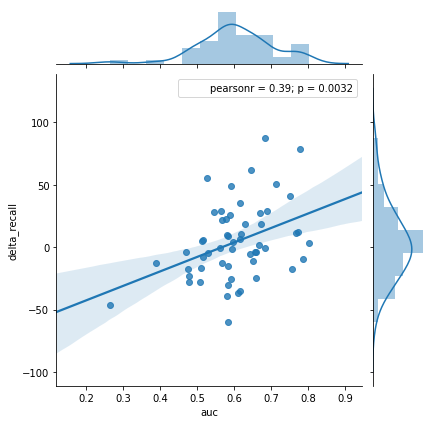

In [29]:
sns.jointplot(x='auc',
              y='delta_recall',
              kind="reg",
              data=combined_df)

In [30]:
# Trained Classifier Dataset
import classiflib

retrained_classifiers = glob.glob(os.path.join(report_db_location, '*retrained_classifier*'))
training_classifier_summary_data = {
    'subject': [],
    'montage': [],
    'training_auc': [],
    'classifier': []
}
for classifier_loc in retrained_classifiers:
    metadata = extract_report_info_from_path(classifier_loc)
    subject = metadata['subject']
    montage = metadata['montage']
    
    # Only add the retrained classifier if one has not already been added
    # for the given subject
    if subject not in training_classifier_summary_data['subject']:
        classifier = classiflib.container.ClassifierContainer.load(classifier_loc)
        training_classifier_summary_data['training_auc'].append(classifier.classifier_info['auc'])
        training_classifier_summary_data['subject'].append(subject)
        training_classifier_summary_data['montage'].append(montage)
        training_classifier_summary_data['classifier'].append(classifier)

trained_classifier_df = pd.DataFrame.from_dict(training_classifier_summary_data)

In [31]:
combined_df = combined_df.merge(trained_classifier_df, how='left')

Let's again check that the merge has worked as expected

In [32]:
assert len(combined_df) == len(session_df)

In [33]:
combined_df[combined_df['classifier'].isnull() == True]

,subject,experiment,montage,session,date,session_summary,electrode_type,location,pulse_freq,stim_duration,delta_recall,classifier_summary,pvalue,auc,classifier,training_auc


In [34]:
combined_df.head()

,subject,experiment,montage,session,date,session_summary,electrode_type,location,pulse_freq,stim_duration,delta_recall,classifier_summary,pvalue,auc,classifier,training_auc
0,R1275D,FR5,0,1,2017-06-10 17:15:09.603000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 1, 'R1275...",,Right Cerebral White Matter,200.0,500.0,35.411540,<ClassifierSummary(_predicted_probabilities=[ ...,0.015,0.616795,<classiflib.container.ClassifierContainer obje...,0.716635
1,R1275D,FR5,0,2,2017-06-11 17:29:07.115000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 2, 'R1275...",,Right Cerebral White Matter,200.0,500.0,-7.532247,<ClassifierSummary(_predicted_probabilities=[ ...,0.410,0.515080,<classiflib.container.ClassifierContainer obje...,0.716635
2,R1292E,FR5,0,0,2017-07-03 16:12:42.221000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 0, 'R1292...",,Left Middle Temporal Gyrus,100.0,500.0,5.376644,<ClassifierSummary(_predicted_probabilities=[ ...,0.390,0.515818,<classiflib.container.ClassifierContainer obje...,0.558089
3,R1304N,FR5,0,0,2017-05-29 15:35:00.879000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 0, 'R1304...",,Right Cerebral White Matter,200.0,500.0,55.067482,<ClassifierSummary(_predicted_probabilities=[ ...,0.315,0.526984,<classiflib.container.ClassifierContainer obje...,0.503983
4,R1308T,FR5,0,0,2017-06-19 20:33:04.856000+00:00,"<FRStimSessionSummary(_events=[ ( 1, 0, 'R1308...",,Left Middle Temporal Gyrus,200.0,500.0,NaN,<ClassifierSummary(_predicted_probabilities=[ ...,0.000,0.705267,<classiflib.container.ClassifierContainer obje...,0.599638


At this point, we have a dataset that contains some basic summary information from each stim session, information about how the classifier performed in the out of sample stim session, and information about the trained classifier. These three pieces of information covers a wide swath of potential analysis use cases. 

## Aggregating to a different level

One lingering concern is that we have so far implicitly assumed that our analysis are based on information at the session level. In many case, we may want to aggregate over sessions that a subject completed, aggregate over all sessions in a particular experiment, or some other aggregation. If we start with our standard session-level dataframe created using pandas magic, this becomes rather trivial to do.

In [35]:
subject_df = (session_df.groupby(by=['subject', 'experiment'])
                        .agg({'session_summary': lambda x: set(np.hstack(x.values)),
                              'session': 'count',
                              'delta_recall': 'mean'})
                        .reset_index())
subject_df.head()

,subject,experiment,session_summary,session,delta_recall
0,R1275D,FR5,"{<FRStimSessionSummary(_events=[ ( 1, 1, 'R127...",2,13.939646
1,R1292E,FR5,"{<FRStimSessionSummary(_events=[ ( 1, 0, 'R129...",1,5.376644
2,R1304N,FR5,"{<FRStimSessionSummary(_events=[ ( 1, 0, 'R130...",1,55.067482
3,R1308T,FR5,"{<FRStimSessionSummary(_events=[ ( 1, 2, 'R130...",3,10.134115
4,R1315T,FR5,"{<FRStimSessionSummary(_events=[ ( 1, 0, 'R131...",1,-4.448695


We now have a basic dataset that is at the subject level where our delta recall measure that we have been interested is now the average across sessions that the subject completed. The other nice thing that we've done is that our session_summary field has not gone away, but rather, it now contains the set of all session summary objects associated with the sessions that the subject completed. This leaves us free to continue writing functions that take a summary object or a list of summary objects and returns some value of interest.